In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it
from glob import glob
from matplotlib import pyplot as plt
from pymea import plotting
from pymea import matlab_compatibility as mc

In [4]:
data_path = '/home/sean/mea data/07/07_spk_freq_table.csv'
data_table = pd.read_csv(data_path)
#time_vector = data_table['time'].map(mc.datetime_str_to_datetime)

In [5]:
def is_top(unit_name):
    row = mc.get_row_number(unit_name)
    if row <= 3:
        return True
    else:
        return False
def is_bottom(unit_name):
    row = mc.get_row_number(unit_name)
    if row > 3:
        return True
    else:
        return False

cond_filt_PO = {
    'PO_20': is_top,
    'PO_3': is_bottom
}

In [6]:
def is_all(unit_name):
    return True

cond_filt = {
    'All': is_all
}

In [7]:
PO_table = plotting.construct_categorized_dataframe(data_table, cond_filt_PO)
PO_table['spike_freq'] = PO_table['spike_freq']/60 # convert from spikes/1 minute to spikes/sec
cat_table = plotting.construct_categorized_dataframe(data_table, cond_filt)
cat_table['spike_freq'] = cat_table['spike_freq']/60 # convert from spikes/1 minute to spikes/sec

In [8]:
cat_table['spike_freq'] = cat_table['spike_freq']/2 # convert from spikes/sec to spikes/pulse
PO_table['spike_freq'] = PO_table['spike_freq']/2 # convert from spikes/sec to spikes/pulse

In [9]:
baseline_table = cat_table.query('time < "2017-09-08 14:55:00"')

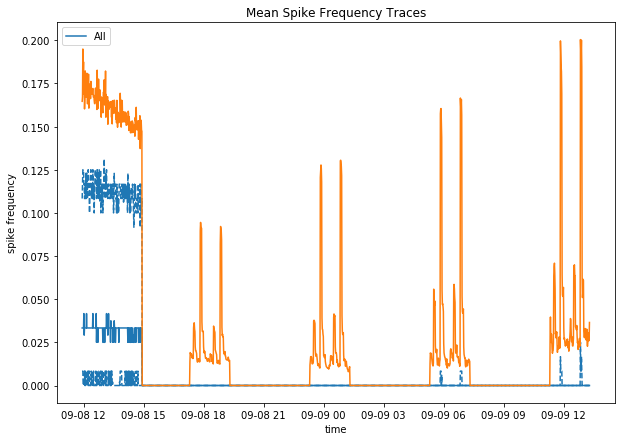

In [32]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(cat_table)
plotting.plot_mean_frequency_traces(cat_table)

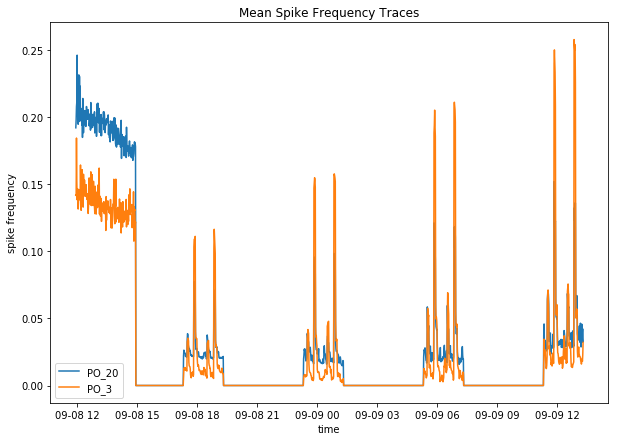

In [124]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(PO_table)

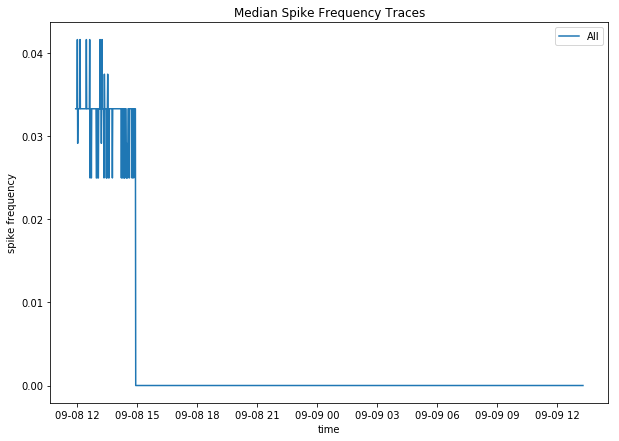

In [10]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(cat_table, quartiles = False)

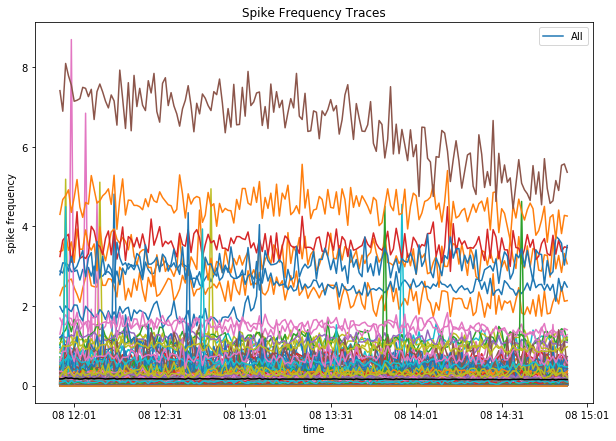

In [32]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces_plus_means(baseline_table)

In [10]:
rec_start_times1 = pd.date_range('2017-09-08 17:19:00', periods = 8, freq = '6H') #skip 1st minute
rec_stop_times1 = pd.date_range('2017-09-08 18:19:00', periods = 8, freq = '6H')
rec_start_times2 = pd.date_range('2017-09-08 18:19:00', periods = 8, freq = '6H') #skip 1st minute
rec_stop_times2 = pd.date_range('2017-09-08 19:19:00', periods = 8, freq = '6H')

rec_start_times = rec_start_times1.append(rec_start_times2)
rec_stop_times = rec_stop_times1.append(rec_stop_times2)

all_recs_table = pd.DataFrame()

for start, stop in zip(rec_start_times, rec_stop_times):
    rec_table = cat_table.query('time > @start and time < @stop')
    rec_table.loc[:,'time'] = rec_table.loc[:,'time'] - start
    all_recs_table = all_recs_table.append(rec_table)

rec_mean = all_recs_table.groupby(('condition','time'))['spike_freq'].mean()
rec_mean = rec_mean.reset_index()

/home/sean/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


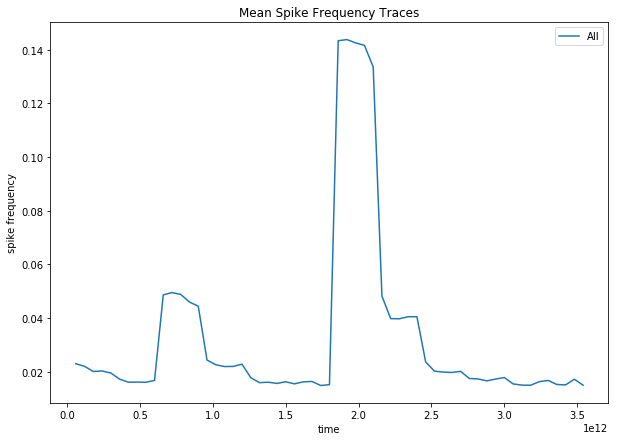

In [19]:
plt.figure(figsize=(10,7))
plotting.plot_mean_frequency_traces(rec_mean)

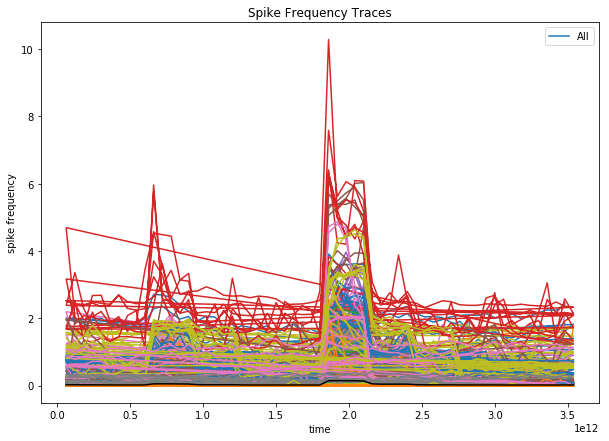

In [20]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces_plus_means(all_recs_table)

In [15]:
def light_response_filter(all_recs_table):
    high_resp = all_recs_table.query('time >= "00:30:00" and time < "00:35:00"')
    high_means = high_resp.groupby('unit_name')['spike_freq'].mean()
    high_means = high_means.reset_index()
    low_resp = all_recs_table.query('time >= "00:50:00" and time < "00:60:00"')
    low_means = low_resp.groupby('unit_name')['spike_freq'].mean()
    low_means = low_means.reset_index()
    filt = high_means['spike_freq'] > low_means['spike_freq']
    return high_means.loc[filt,'unit_name']

In [16]:
filtered_units = light_response_filter(all_recs_table)
filtered_table = all_recs_table.loc[all_recs_table['unit_name'].isin(filtered_units)]

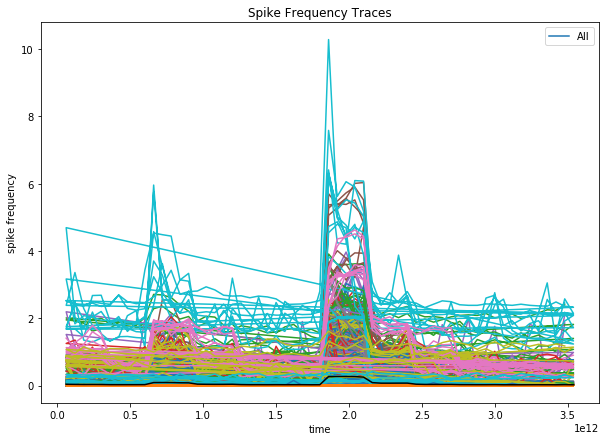

In [23]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces_plus_means(filtered_table)
#plt.yscale('log')

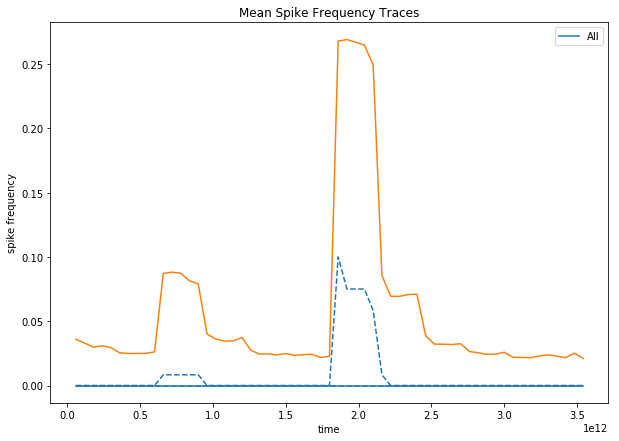

In [24]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(filtered_table)
plotting.plot_mean_frequency_traces(filtered_table)

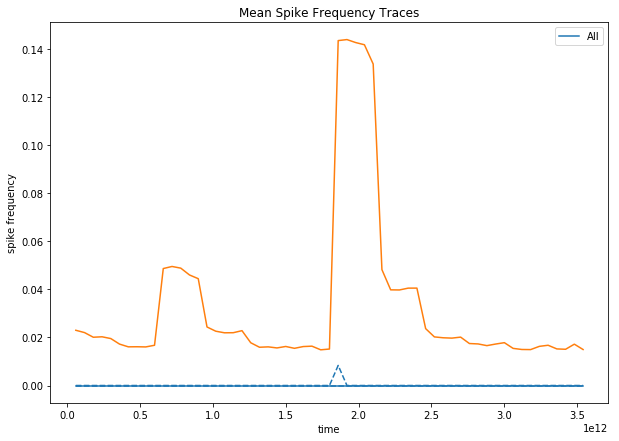

In [13]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(all_recs_table)
plotting.plot_mean_frequency_traces(all_recs_table)

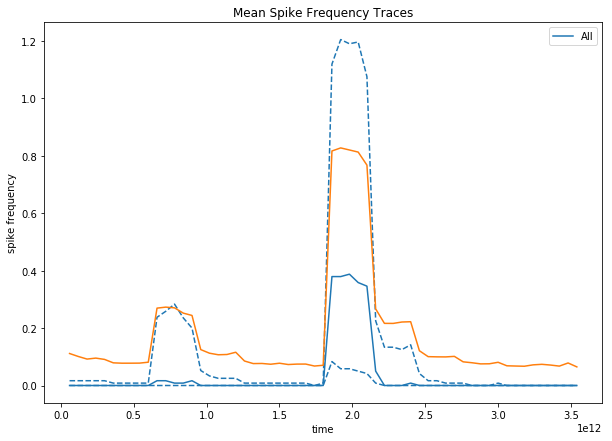

In [30]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(non_zero)
plotting.plot_mean_frequency_traces(non_zero)

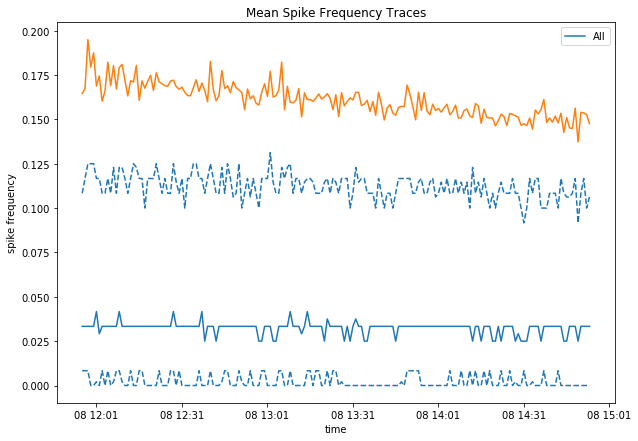

In [30]:
plt.figure(figsize=(10,7))
plotting.plot_median_frequency_traces(baseline_table)
plotting.plot_mean_frequency_traces(baseline_table)

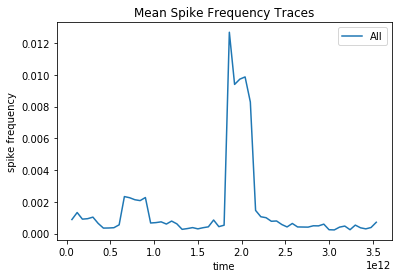

In [99]:
plotting.plot_mean_frequency_traces(slow_table)

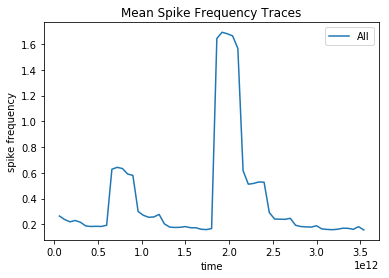

In [102]:
plotting.plot_mean_frequency_traces(fast_table)

In [11]:
def mean_freq_hist(category_dataframe):
    unit_freq_mean = category_dataframe.groupby(('unit_name'))['spike_freq'].mean()
    unit_freq_mean = unit_freq_mean.rename('spike frequency').reset_index() # Convert the multiindexed series back to a dataframe
    #print(unit_freq_mean)
    plt.hist(unit_freq_mean['spike frequency'], bins = 50)
    plt.title('Mean Firing Rate per Unit')

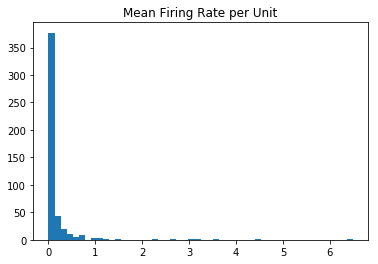

In [86]:
mean_freq_hist(baseline_table)

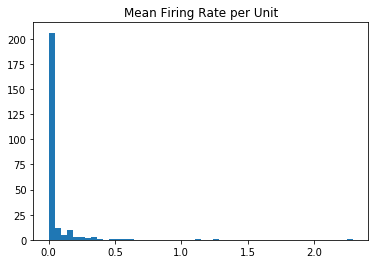

In [87]:
mean_freq_hist(filtered_table)

In [12]:
def select_neurons(cat_table, min_freq = 0, max_freq = 100000):
    """
    Returns a version of cat_table only containing units whose mean frequency is between min_freq and max_freq
    """
    unit_freq_mean = cat_table.groupby(('unit_name'))['spike_freq'].mean()
    unit_freq_mean = unit_freq_mean.rename('spike_freq').reset_index()
    filt = (unit_freq_mean['spike_freq'] > min_freq) & (unit_freq_mean['spike_freq'] < max_freq)
    selected_units = unit_freq_mean.loc[filt,'unit_name']
    return (cat_table.loc[cat_table['unit_name'].isin(selected_units)], selected_units)

In [17]:
(slow_table, slow_units) = select_neurons(filtered_table, max_freq = 0.01)
(fast_table, fast_units) = select_neurons(filtered_table, min_freq = 0.1)
(non_zero, non_zero_units) = select_neurons(filtered_table, min_freq = 0.01)

In [34]:
len(fast_table['unit_name'].unique())

31

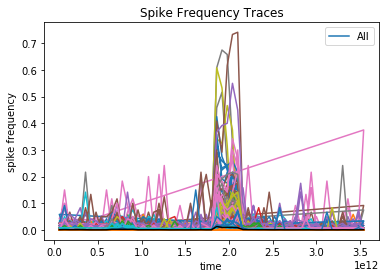

In [104]:
plotting.plot_unit_traces_plus_means(slow_table)

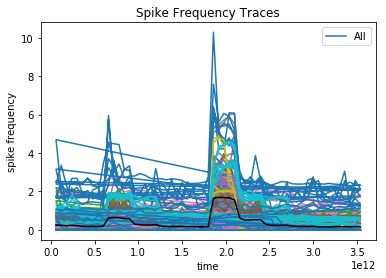

In [105]:
plotting.plot_unit_traces_plus_means(fast_table)

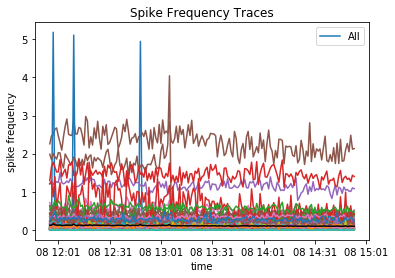

In [109]:
plotting.plot_unit_traces_plus_means(baseline_table.loc[baseline_table['unit_name'].isin(slow_units)])

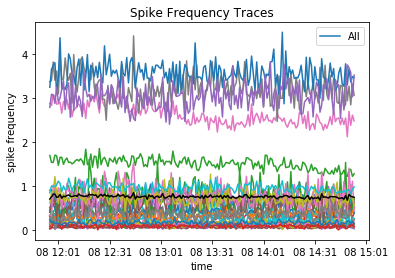

In [112]:
plotting.plot_unit_traces_plus_means(baseline_table.loc[baseline_table['unit_name'].isin(fast_units)])

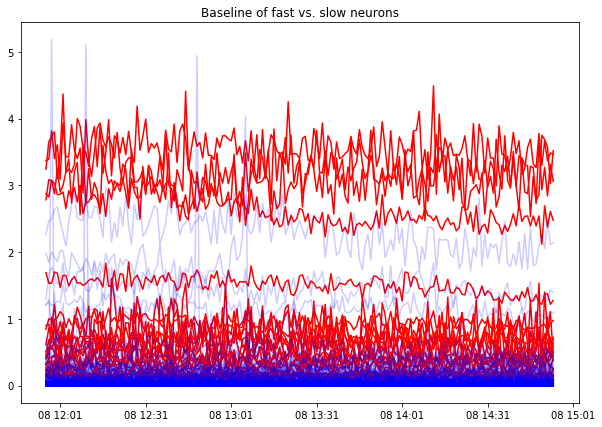

In [18]:
plt.figure(figsize=(10,7))
plotting.plot_unit_traces(baseline_table.loc[baseline_table['unit_name'].isin(fast_units)], color = 'r')
plotting.plot_unit_traces(baseline_table.loc[baseline_table['unit_name'].isin(slow_units)], color = 'b', alpha = 0.2)
plt.title("Baseline of fast vs. slow neurons")